This tutorial shows how to run Distributed Dask from your Kubernetes cluster. Dask is a distributed implementation of the pandas DataFrame that behaves similarly to Spark with methods that lazy-evaluate and a scheduler/worker model. Parallelizing computations can lead to an increase in performance for many operations on columnar data.

Common libraries such as matplotlib, numpy, and scikit-learn also can be seamlessly integrated with the distributed environment allowing more efficient workflows for data analysis.

[Installation through the Helm repository](http://dask.pydata.org/en/latest/setup/kubernetes-helm.html) comes with an installation of JupyterLab, three workers, and standard conda packages. This configuration is great for analyzing data slightly larger than available memory, but it can also scale for much larger projects.

## Prerequisites
This tutorial assumes the following:

 * You have a local Linux/Unix environment.
 * You successfully installed Helm on your local computer and initialized Tiller on your cluster.

On your local development environment, check if Helm is installed.

```
$ helm version
Client: &version.Version{SemVer:"v2.8.1", GitCommit:"6af75a8fd72e2aa18a2b278cfe5c7a1c5feca7f2", GitTreeState:"clean"}
Server: &version.Version{SemVer:"v2.8.1", GitCommit:"6af75a8fd72e2aa18a2b278cfe5c7a1c5feca7f2", GitTreeState:"clean"}
```

Make sure to update with `helm init --upgrade` if needed.

Verify Tiller is running on the cluster. There should be a running pod for Tiller in the kube-system namespace.

```
$ kubectl get pods --namespace kube-system
NAME                                    READY     STATUS    RESTARTS   AGE
calico-node-dd7v2                       1/1       Running   0          6h
calico-node-q8lqd                       1/1       Running   0          6h
calico-node-xbpkj                       1/1       Running   0          6h
kube-apiserver-node1                    1/1       Running   0          6h
kube-apiserver-node2                    1/1       Running   0          6h
kube-controller-manager-node1           1/1       Running   0          6h
kube-controller-manager-node2           1/1       Running   0          6h
kube-dns-79d99cdcd5-gdtls               3/3       Running   0          6h
kube-dns-79d99cdcd5-hmrk6               3/3       Running   0          6h
kube-proxy-node1                        1/1       Running   0          6h
kube-proxy-node2                        1/1       Running   0          6h
kube-proxy-node3                        1/1       Running   0          6h
kube-scheduler-node1                    1/1       Running   0          6h
kube-scheduler-node2                    1/1       Running   0          6h
kubedns-autoscaler-5564b5585f-hxxrm     1/1       Running   0          6h
kubernetes-dashboard-69cb58d748-v2ld9   1/1       Running   0          6h
nginx-proxy-node3                       1/1       Running   0          6h
tiller-deploy-5b48764ff7-pzxtr          1/1       Running   0          6h
```


### Install Dask with Helm
Although there is another chart called `dask-distributed`, it has been deprecated and distributed functionality is now included in `dask`.

Add the `dask` repository on Helm:

```
$ helm repo add dask https://dask.github.io/helm-chart
"dask" has been added to your repositories
```

Update the chart repositories:

```
$ helm repo update
Hang tight while we grab the latest from your chart repositories...
...Skip local chart repository
...Successfully got an update from the "dask" chart repository
...Successfully got an update from the "stable" chart repository
Update Complete. ⎈ Happy Helming!⎈
```

Install Dask on Kubernetes using Helm. The name of the Dask deployment is named `killjoy-robin` in this example.

```
$ helm install dask/dask
NAME:   killjoy-robin
LAST DEPLOYED: Sat Mar 17 08:20:45 2018
NAMESPACE: default
STATUS: DEPLOYED

...
  ```

List all running services. The `CLUSTER-IP` column contains the private IP for communication within the cluster.

```
$ kubectl get services
NAME                           TYPE           CLUSTER-IP      EXTERNAL-IP   PORT(S)                       AGE
killjoy-robin-dask-jupyter     LoadBalancer   10.233.47.165   <pending>     80:32049/TCP                  1d
killjoy-robin-dask-scheduler   LoadBalancer   10.233.58.126   <pending>     8786:30119/TCP,80:32468/TCP   1d
kubernetes                     ClusterIP      10.233.0.1      <none>        443/TCP                       1d
```

### Use SSH Tunnel to Run JupyterLab Locally
Exposing JupyterLab publically is not recommended because comes with an additional set of security considarations. An SSH tunnel to the JupyterLab environment allows a secure way of connecting to the Dask environment.

An SSH tunnel follows the following syntax:

`ssh user@example-ip -L 8888:CLUSTER-IP:80 -N`

From the list of running of services above, forward the internal cluster IP of `dask-jupyter` on port 80 to port 8888 on the local computer.

On a browser, go to `localhost:8888`. The login page will appear, and the default notebook password is: `dask`. The JupyterLab environment can open a Python shell, terminal, or an IPython notebook.

![JupyterLab Dashboard](dashboard.png)

### Using Dask on JupyterLab
This section shows an example workflow on how to load to a CSV file into a Dask Dataframe then see how the scheduler will allocate computation to each worker.

Open a new notebook though JupyterLab. A new client object shows the number of cores and memory available on the Dask cluster. The scheduler can also be viewed through a similar manner by forwarding port 8786. This example uses a VPS of three nodes with 1 virtualized CPU core and 2GB RAM each.

In [1]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://killjoy-robin-dask-scheduler:8786 Dashboard: http://killjoy-robin-dask-scheduler:8787/status,Cluster Workers: 3 Cores: 3 Memory: 6.25 GB


Bash commands can be executed directly in the cell by prepending the command with an exclamation mark. Download the Iris dataset from the UCI archive using `wget`.

In [2]:
!wget -O iris.csv https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

--2018-03-19 17:19:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [text/plain]
Saving to: ‘iris.csv’

iris.csv            100%[===================>]   4.44K  --.-KB/s    in 0s      

2018-03-19 17:19:32 (116 MB/s) - ‘iris.csv’ saved [4551/4551]



This example shows how to load a CSV file into memory and scatter among each worker. For larger datasets that cannot be loaded into memory, a shared filesystem such as HDFS should be used instead. The CSV file is partitioned among the workers.

In [3]:
import pandas as pd
import dask.dataframe as dd

df = pd.read_csv('iris.csv', header=None)
future = client.scatter(df)
ddf = dd.from_delayed([future], meta=df)
ddf = ddf.repartition(npartitions=20).persist()
client.rebalance(ddf)

Most of the DataFrame API from Dask is identical to pandas. The `head()` method will print the first five rows of the DataFrame.

In [4]:
ddf.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Accessing a column in the DataFrame shows the number of partitions (20) that was set earlier.

In [5]:
ddf[0]

Dask Series Structure:
npartitions=20
    float64
        ...
     ...   
        ...
        ...
Name: 0, dtype: float64
Dask Name: getitem, 40 tasks

Unlike operations in native Python, the sum method will lazy evaluate.

In [6]:
ddf[0].sum()

dd.Scalar<series-..., dtype=float64>

Execution of the method can be visualized though the `visualize()` method or evaluated with `compute()`.

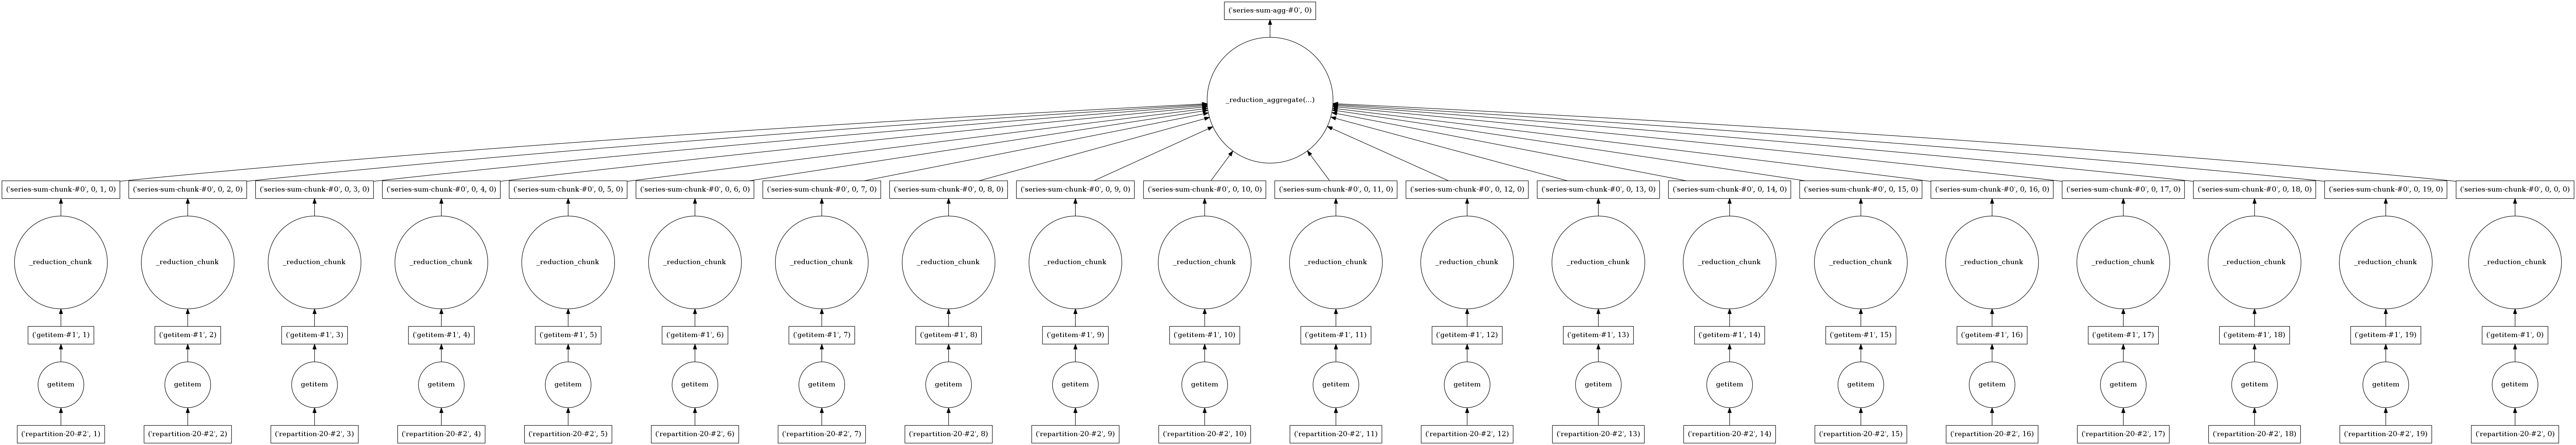

In [7]:
ddf[0].sum().visualize()

In [8]:
ddf[0].sum().compute()

876.4999999999999

### Increase Workers and Scaling

The number of workers and limits on allocated resources can be modified though a YAML configuration then upgrading the deployment through Helm. This configuration will add the `requests` library on the Jupyter and worker environments.


Create a `config.yaml` file with the following configuration:

```
worker:
  replicas: 3
  limits:
    cpu: 2
    memory: 7.5 GiB
  pipPackages: >-
    git+https://github.com/dask/gcsfs.git
    git+https://github.com/xarray/xarray.git
    git+https://github.com/requests/requests.git
  condaPackages: >-
    -c conda-forge
    zarr
    blosc

# We want to keep the same packages on the worker and jupyter environments
jupyter:
  pipPackages: >-
    git+https://github.com/dask/gcsfs.git
    git+https://github.com/xarray/xarray.git
    git+https://github.com/requests/requests.git
  condaPackages: >-
    -c conda-forge
    zarr
    blosc
```

Then upgrade the deployment by running:

`helm upgrade killjoy-robin dask/dask -f config.yaml`

Dask is a lightweight alternative to Spark and offers flexibility to interoperate with the Python ecosystem. There are certain operations that benefit from parallelizing the workload to workers while [others are not recommended](https://dask.pydata.org/en/latest/dataframe.html#common-uses-and-anti-uses). Although it is not a replacement for Spark, Dask offers valuable features for anyone working with large quantities of data.